In [1]:
import onnxruntime as ort
import onnx
import torch
from imagen_pytorch.t5 import t5_encode_text
from einops import rearrange, repeat, reduce, pack, unpack
import numpy as np
from tqdm import tqdm
import torchvision.transforms as T
import json

NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Python310\lib\site-packages\beartype\_util\hint\pep\utilpeptest.py:345: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.List[str] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". See this discussion for further details and alternatives:
    https://github.com/beartype/beartype#pep-585-deprecations
  warn(


In [2]:
enc, mask = t5_encode_text(["a photo of a truck"], return_attn_mask = True)
# out = u.sample(enc, mask, 1., torch.device('cuda'), use_tqdm=False)
# print(out)
# img = T.ToPILImage()(out[0])
# img.save("truck-12.png")
# img

In [3]:
enc

tensor([[[-0.0488,  0.0970, -0.0506,  ...,  0.0273,  0.1872,  0.0680],
         [-0.1462,  0.1518, -0.0457,  ...,  0.1244,  0.2352,  0.1052],
         [ 0.1742,  0.0629,  0.0402,  ...,  0.2023,  0.0219, -0.2089],
         ...,
         [ 0.1827,  0.0657,  0.1491,  ..., -0.0903, -0.0265,  0.1046],
         [ 0.0444,  0.1756, -0.0850,  ..., -0.1722,  0.0901,  0.1011],
         [ 0.0074,  0.0045,  0.0046,  ..., -0.0018,  0.0175,  0.0081]]],
       device='cuda:0')

In [4]:
ort_session = ort.InferenceSession("toymodel/build/unet-32.onnx")

In [5]:
def get_sampling_timesteps(num_timesteps, batch, *, device):
    times = torch.linspace(1., 0., num_timesteps + 1, device = device)
    times = repeat(times, 't -> b t', b = batch)
    times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
    times = times.unbind(dim = -1)
    return times

In [6]:
# outputs = ort_session.run(
#     None,
#     {
#             'image': np.array(torch.randn(1, 3, 32, 32)).astype(np.float32), 
#             'text_embeds': np.array(enc.cpu()).astype(np.float32),
#             'text_mask': np.array(mask.cpu()),
#             'timestep': np.array(torch.Tensor([0.99])).astype(np.float32),
#             'time_next': np.array(torch.Tensor([0.95])).astype(np.float32),
#             'cond_scale': np.array([1.]).astype(np.float32)
#     })

In [7]:
timesteps = get_sampling_timesteps(250, 1, device=torch.device('cpu'))

In [8]:
img = np.array(torch.randn(1, 3, 32, 32)).astype(np.float32)

In [8]:
# enc_arry = np.array(enc.cpu()).astype(np.float32)
# mask_arry = np.array(mask.cpu())
# ts = np.array([0.996]).astype(np.float32)
# next_ts = np.array([0.992]).astype(np.float32)
# cond_scale = np.array([1.1]).astype(np.float32)

# outputs = ort_session.run(
#         None,
#         {
#                 'image': img,
#                 'text_embeds': enc_arry,
#                 'text_mask': mask_arry,
#                 'timestep': ts,
#                 'time_next': next_ts,
#                 'cond_scale': cond_scale
#         }
#     )

# data = {}

# data['image'] = img.tolist()
# data['text_embeds'] = enc_arry.tolist()
# data['text_mask'] = mask_arry.tolist()
# data['timestep'] = ts.tolist()
# data['time_next'] = next_ts.tolist()
# data['cond_scale'] = cond_scale.tolist()
# data['expected'] = outputs[0].tolist()

# with open('toymodel/public/inputs.json', 'w') as f:
#     json.dump(data, f)

In [3]:
# with open('toymodel/public/inputs.json') as f:
#     data = json.load(f)

In [26]:
# second = ort_session.run(
#         None,
#         {
#                 'image': np.array(data['image']).astype(np.float32),
#                 'text_embeds': np.array(data['text_embeds']).astype(np.float32),
#                 'text_mask': np.array(data['text_mask']),
#                 'timestep': np.array(data['timestep']).astype(np.float32),
#                 'time_next': np.array(data['time_next']).astype(np.float32),
#                 'cond_scale': np.array(data['cond_scale']).astype(np.float32)
#         }
#     )

In [9]:
img = np.array(torch.randn(1, 3, 32, 32)).astype(np.float32)

count = 0
for t, t_next in tqdm(timesteps[1:250]):
    print(t, t_next)
    outputs = ort_session.run(
        None,
        {
                'image': img,
                'text_embeds': np.array(enc.cpu()).astype(np.float32),
                'text_mask': np.array(mask.cpu()),
                'timestep': np.array(t).astype(np.float32),
                'time_next': np.array(t_next).astype(np.float32),
                'cond_scale': np.array([1.]).astype(np.float32)
        }
    )
    
    img = outputs[0]
    
    final = (torch.clamp(torch.Tensor(img), -1, 1) + 1) * 0.5
    final = T.ToPILImage()(final[0])
    final.save(f"truck-{count}.png")
    final
    
    count += 1

  0%|▎                                                                                 | 1/249 [00:00<00:50,  4.96it/s]

tensor([0.9960]) tensor([0.9920])


  1%|▋                                                                                 | 2/249 [00:00<00:39,  6.19it/s]

tensor([0.9920]) tensor([0.9880])
tensor([0.9880]) tensor([0.9840])


  2%|█▎                                                                                | 4/249 [00:00<00:36,  6.63it/s]

tensor([0.9840]) tensor([0.9800])
tensor([0.9800]) tensor([0.9760])


  2%|█▉                                                                                | 6/249 [00:00<00:34,  6.97it/s]

tensor([0.9760]) tensor([0.9720])
tensor([0.9720]) tensor([0.9680])


  3%|██▋                                                                               | 8/249 [00:01<00:34,  6.96it/s]

tensor([0.9680]) tensor([0.9640])
tensor([0.9640]) tensor([0.9600])


  4%|███▎                                                                             | 10/249 [00:01<00:33,  7.08it/s]

tensor([0.9600]) tensor([0.9560])
tensor([0.9560]) tensor([0.9520])


  5%|███▉                                                                             | 12/249 [00:01<00:34,  6.88it/s]

tensor([0.9520]) tensor([0.9480])
tensor([0.9480]) tensor([0.9440])


  6%|████▌                                                                            | 14/249 [00:02<00:34,  6.80it/s]

tensor([0.9440]) tensor([0.9400])
tensor([0.9400]) tensor([0.9360])


  6%|█████▏                                                                           | 16/249 [00:02<00:34,  6.81it/s]

tensor([0.9360]) tensor([0.9320])
tensor([0.9320]) tensor([0.9280])


  7%|█████▊                                                                           | 18/249 [00:02<00:34,  6.77it/s]

tensor([0.9280]) tensor([0.9240])
tensor([0.9240]) tensor([0.9200])


  8%|██████▌                                                                          | 20/249 [00:02<00:33,  6.84it/s]

tensor([0.9200]) tensor([0.9160])
tensor([0.9160]) tensor([0.9120])


  9%|███████▏                                                                         | 22/249 [00:03<00:32,  7.01it/s]

tensor([0.9120]) tensor([0.9080])
tensor([0.9080]) tensor([0.9040])


 10%|███████▊                                                                         | 24/249 [00:03<00:31,  7.13it/s]

tensor([0.9040]) tensor([0.9000])
tensor([0.9000]) tensor([0.8960])


 10%|████████▍                                                                        | 26/249 [00:03<00:31,  7.08it/s]

tensor([0.8960]) tensor([0.8920])
tensor([0.8920]) tensor([0.8880])


 11%|█████████                                                                        | 28/249 [00:04<00:31,  7.04it/s]

tensor([0.8880]) tensor([0.8840])
tensor([0.8840]) tensor([0.8800])


 12%|█████████▊                                                                       | 30/249 [00:04<00:31,  7.04it/s]

tensor([0.8800]) tensor([0.8760])
tensor([0.8760]) tensor([0.8720])


 13%|██████████▍                                                                      | 32/249 [00:04<00:30,  7.00it/s]

tensor([0.8720]) tensor([0.8680])
tensor([0.8680]) tensor([0.8640])


 14%|███████████                                                                      | 34/249 [00:04<00:32,  6.54it/s]

tensor([0.8640]) tensor([0.8600])
tensor([0.8600]) tensor([0.8560])


 14%|███████████▋                                                                     | 36/249 [00:05<00:31,  6.71it/s]

tensor([0.8560]) tensor([0.8520])
tensor([0.8520]) tensor([0.8480])


 15%|████████████▎                                                                    | 38/249 [00:05<00:30,  6.88it/s]

tensor([0.8480]) tensor([0.8440])
tensor([0.8440]) tensor([0.8400])


 16%|█████████████                                                                    | 40/249 [00:05<00:29,  6.97it/s]

tensor([0.8400]) tensor([0.8360])
tensor([0.8360]) tensor([0.8320])


 17%|█████████████▋                                                                   | 42/249 [00:06<00:29,  7.11it/s]

tensor([0.8320]) tensor([0.8280])
tensor([0.8280]) tensor([0.8240])


 18%|██████████████▎                                                                  | 44/249 [00:06<00:28,  7.14it/s]

tensor([0.8240]) tensor([0.8200])
tensor([0.8200]) tensor([0.8160])


 18%|██████████████▉                                                                  | 46/249 [00:06<00:28,  7.03it/s]

tensor([0.8160]) tensor([0.8120])
tensor([0.8120]) tensor([0.8080])


 19%|███████████████▌                                                                 | 48/249 [00:06<00:28,  6.94it/s]

tensor([0.8080]) tensor([0.8040])
tensor([0.8040]) tensor([0.8000])


 20%|████████████████▎                                                                | 50/249 [00:07<00:28,  6.97it/s]

tensor([0.8000]) tensor([0.7960])
tensor([0.7960]) tensor([0.7920])


 21%|████████████████▉                                                                | 52/249 [00:07<00:27,  7.06it/s]

tensor([0.7920]) tensor([0.7880])
tensor([0.7880]) tensor([0.7840])


 22%|█████████████████▌                                                               | 54/249 [00:07<00:27,  7.02it/s]

tensor([0.7840]) tensor([0.7800])
tensor([0.7800]) tensor([0.7760])


 22%|██████████████████▏                                                              | 56/249 [00:08<00:27,  7.11it/s]

tensor([0.7760]) tensor([0.7720])
tensor([0.7720]) tensor([0.7680])


 23%|██████████████████▊                                                              | 58/249 [00:08<00:26,  7.17it/s]

tensor([0.7680]) tensor([0.7640])
tensor([0.7640]) tensor([0.7600])


 24%|███████████████████▌                                                             | 60/249 [00:08<00:27,  6.99it/s]

tensor([0.7600]) tensor([0.7560])
tensor([0.7560]) tensor([0.7520])


 25%|████████████████████▏                                                            | 62/249 [00:08<00:26,  6.93it/s]

tensor([0.7520]) tensor([0.7480])
tensor([0.7480]) tensor([0.7440])


 26%|████████████████████▊                                                            | 64/249 [00:09<00:26,  7.01it/s]

tensor([0.7440]) tensor([0.7400])
tensor([0.7400]) tensor([0.7360])


 27%|█████████████████████▍                                                           | 66/249 [00:09<00:26,  7.03it/s]

tensor([0.7360]) tensor([0.7320])
tensor([0.7320]) tensor([0.7280])


 27%|██████████████████████                                                           | 68/249 [00:09<00:25,  7.06it/s]

tensor([0.7280]) tensor([0.7240])
tensor([0.7240]) tensor([0.7200])


 28%|██████████████████████▊                                                          | 70/249 [00:10<00:25,  7.15it/s]

tensor([0.7200]) tensor([0.7160])
tensor([0.7160]) tensor([0.7120])


 29%|███████████████████████▍                                                         | 72/249 [00:10<00:25,  7.00it/s]

tensor([0.7120]) tensor([0.7080])
tensor([0.7080]) tensor([0.7040])


 30%|████████████████████████                                                         | 74/249 [00:10<00:24,  7.10it/s]

tensor([0.7040]) tensor([0.7000])
tensor([0.7000]) tensor([0.6960])


 31%|████████████████████████▋                                                        | 76/249 [00:10<00:24,  7.09it/s]

tensor([0.6960]) tensor([0.6920])
tensor([0.6920]) tensor([0.6880])


 31%|█████████████████████████▎                                                       | 78/249 [00:11<00:24,  7.05it/s]

tensor([0.6880]) tensor([0.6840])
tensor([0.6840]) tensor([0.6800])


 32%|██████████████████████████                                                       | 80/249 [00:11<00:23,  7.24it/s]

tensor([0.6800]) tensor([0.6760])
tensor([0.6760]) tensor([0.6720])


 33%|██████████████████████████▋                                                      | 82/249 [00:11<00:23,  7.13it/s]

tensor([0.6720]) tensor([0.6680])
tensor([0.6680]) tensor([0.6640])


 34%|███████████████████████████▎                                                     | 84/249 [00:12<00:23,  7.01it/s]

tensor([0.6640]) tensor([0.6600])
tensor([0.6600]) tensor([0.6560])


 35%|███████████████████████████▉                                                     | 86/249 [00:12<00:22,  7.14it/s]

tensor([0.6560]) tensor([0.6520])
tensor([0.6520]) tensor([0.6480])


 35%|████████████████████████████▋                                                    | 88/249 [00:12<00:22,  7.09it/s]

tensor([0.6480]) tensor([0.6440])
tensor([0.6440]) tensor([0.6400])


 36%|█████████████████████████████▎                                                   | 90/249 [00:12<00:21,  7.23it/s]

tensor([0.6400]) tensor([0.6360])
tensor([0.6360]) tensor([0.6320])


 37%|█████████████████████████████▉                                                   | 92/249 [00:13<00:22,  7.00it/s]

tensor([0.6320]) tensor([0.6280])
tensor([0.6280]) tensor([0.6240])


 38%|██████████████████████████████▌                                                  | 94/249 [00:13<00:21,  7.11it/s]

tensor([0.6240]) tensor([0.6200])
tensor([0.6200]) tensor([0.6160])


 39%|███████████████████████████████▏                                                 | 96/249 [00:13<00:21,  7.05it/s]

tensor([0.6160]) tensor([0.6120])
tensor([0.6120]) tensor([0.6080])


 39%|███████████████████████████████▉                                                 | 98/249 [00:13<00:20,  7.26it/s]

tensor([0.6080]) tensor([0.6040])
tensor([0.6040]) tensor([0.6000])


 40%|████████████████████████████████▏                                               | 100/249 [00:14<00:20,  7.19it/s]

tensor([0.6000]) tensor([0.5960])
tensor([0.5960]) tensor([0.5920])


 41%|████████████████████████████████▊                                               | 102/249 [00:14<00:20,  7.12it/s]

tensor([0.5920]) tensor([0.5880])
tensor([0.5880]) tensor([0.5840])


 42%|█████████████████████████████████▍                                              | 104/249 [00:14<00:20,  7.11it/s]

tensor([0.5840]) tensor([0.5800])
tensor([0.5800]) tensor([0.5760])


 43%|██████████████████████████████████                                              | 106/249 [00:15<00:19,  7.17it/s]

tensor([0.5760]) tensor([0.5720])
tensor([0.5720]) tensor([0.5680])


 43%|██████████████████████████████████▋                                             | 108/249 [00:15<00:20,  6.94it/s]

tensor([0.5680]) tensor([0.5640])
tensor([0.5640]) tensor([0.5600])


 44%|███████████████████████████████████▎                                            | 110/249 [00:15<00:19,  6.97it/s]

tensor([0.5600]) tensor([0.5560])
tensor([0.5560]) tensor([0.5520])


 45%|███████████████████████████████████▉                                            | 112/249 [00:15<00:19,  7.15it/s]

tensor([0.5520]) tensor([0.5480])
tensor([0.5480]) tensor([0.5440])


 46%|████████████████████████████████████▋                                           | 114/249 [00:16<00:19,  7.09it/s]

tensor([0.5440]) tensor([0.5400])
tensor([0.5400]) tensor([0.5360])


 47%|█████████████████████████████████████▎                                          | 116/249 [00:16<00:18,  7.16it/s]

tensor([0.5360]) tensor([0.5320])
tensor([0.5320]) tensor([0.5280])


 47%|█████████████████████████████████████▉                                          | 118/249 [00:16<00:18,  7.10it/s]

tensor([0.5280]) tensor([0.5240])
tensor([0.5240]) tensor([0.5200])


 48%|██████████████████████████████████████▌                                         | 120/249 [00:17<00:18,  7.10it/s]

tensor([0.5200]) tensor([0.5160])
tensor([0.5160]) tensor([0.5120])


 49%|███████████████████████████████████████▏                                        | 122/249 [00:17<00:17,  7.10it/s]

tensor([0.5120]) tensor([0.5080])
tensor([0.5080]) tensor([0.5040])


 50%|███████████████████████████████████████▊                                        | 124/249 [00:17<00:17,  6.98it/s]

tensor([0.5040]) tensor([0.5000])
tensor([0.5000]) tensor([0.4960])


 51%|████████████████████████████████████████▍                                       | 126/249 [00:17<00:17,  7.03it/s]

tensor([0.4960]) tensor([0.4920])
tensor([0.4920]) tensor([0.4880])


 51%|█████████████████████████████████████████                                       | 128/249 [00:18<00:17,  7.01it/s]

tensor([0.4880]) tensor([0.4840])
tensor([0.4840]) tensor([0.4800])


 52%|█████████████████████████████████████████▊                                      | 130/249 [00:18<00:16,  7.02it/s]

tensor([0.4800]) tensor([0.4760])
tensor([0.4760]) tensor([0.4720])


 53%|██████████████████████████████████████████▍                                     | 132/249 [00:18<00:16,  7.17it/s]

tensor([0.4720]) tensor([0.4680])
tensor([0.4680]) tensor([0.4640])


 54%|███████████████████████████████████████████                                     | 134/249 [00:19<00:16,  7.02it/s]

tensor([0.4640]) tensor([0.4600])
tensor([0.4600]) tensor([0.4560])


 55%|███████████████████████████████████████████▋                                    | 136/249 [00:19<00:16,  7.03it/s]

tensor([0.4560]) tensor([0.4520])
tensor([0.4520]) tensor([0.4480])


 55%|████████████████████████████████████████████▎                                   | 138/249 [00:19<00:15,  6.97it/s]

tensor([0.4480]) tensor([0.4440])
tensor([0.4440]) tensor([0.4400])


 56%|████████████████████████████████████████████▉                                   | 140/249 [00:19<00:15,  7.01it/s]

tensor([0.4400]) tensor([0.4360])
tensor([0.4360]) tensor([0.4320])


 57%|█████████████████████████████████████████████▌                                  | 142/249 [00:20<00:15,  7.13it/s]

tensor([0.4320]) tensor([0.4280])
tensor([0.4280]) tensor([0.4240])


 58%|██████████████████████████████████████████████▎                                 | 144/249 [00:20<00:14,  7.02it/s]

tensor([0.4240]) tensor([0.4200])
tensor([0.4200]) tensor([0.4160])


 59%|██████████████████████████████████████████████▉                                 | 146/249 [00:20<00:14,  7.02it/s]

tensor([0.4160]) tensor([0.4120])
tensor([0.4120]) tensor([0.4080])


 59%|███████████████████████████████████████████████▌                                | 148/249 [00:21<00:14,  7.18it/s]

tensor([0.4080]) tensor([0.4040])
tensor([0.4040]) tensor([0.4000])


 60%|████████████████████████████████████████████████▏                               | 150/249 [00:21<00:13,  7.12it/s]

tensor([0.4000]) tensor([0.3960])
tensor([0.3960]) tensor([0.3920])


 61%|████████████████████████████████████████████████▊                               | 152/249 [00:21<00:14,  6.90it/s]

tensor([0.3920]) tensor([0.3880])
tensor([0.3880]) tensor([0.3840])


 62%|█████████████████████████████████████████████████▍                              | 154/249 [00:21<00:13,  7.12it/s]

tensor([0.3840]) tensor([0.3800])
tensor([0.3800]) tensor([0.3760])


 63%|██████████████████████████████████████████████████                              | 156/249 [00:22<00:13,  7.07it/s]

tensor([0.3760]) tensor([0.3720])
tensor([0.3720]) tensor([0.3680])


 63%|██████████████████████████████████████████████████▊                             | 158/249 [00:22<00:12,  7.15it/s]

tensor([0.3680]) tensor([0.3640])
tensor([0.3640]) tensor([0.3600])


 64%|███████████████████████████████████████████████████▍                            | 160/249 [00:22<00:12,  6.94it/s]

tensor([0.3600]) tensor([0.3560])
tensor([0.3560]) tensor([0.3520])


 65%|████████████████████████████████████████████████████                            | 162/249 [00:23<00:12,  7.01it/s]

tensor([0.3520]) tensor([0.3480])
tensor([0.3480]) tensor([0.3440])


 66%|████████████████████████████████████████████████████▋                           | 164/249 [00:23<00:12,  6.99it/s]

tensor([0.3440]) tensor([0.3400])
tensor([0.3400]) tensor([0.3360])


 67%|█████████████████████████████████████████████████████▎                          | 166/249 [00:23<00:11,  7.07it/s]

tensor([0.3360]) tensor([0.3320])
tensor([0.3320]) tensor([0.3280])


 67%|█████████████████████████████████████████████████████▉                          | 168/249 [00:23<00:11,  6.95it/s]

tensor([0.3280]) tensor([0.3240])
tensor([0.3240]) tensor([0.3200])


 68%|██████████████████████████████████████████████████████▌                         | 170/249 [00:24<00:11,  7.00it/s]

tensor([0.3200]) tensor([0.3160])
tensor([0.3160]) tensor([0.3120])


 69%|███████████████████████████████████████████████████████▎                        | 172/249 [00:24<00:11,  6.90it/s]

tensor([0.3120]) tensor([0.3080])
tensor([0.3080]) tensor([0.3040])


 70%|███████████████████████████████████████████████████████▉                        | 174/249 [00:24<00:10,  7.01it/s]

tensor([0.3040]) tensor([0.3000])
tensor([0.3000]) tensor([0.2960])


 71%|████████████████████████████████████████████████████████▌                       | 176/249 [00:25<00:10,  6.85it/s]

tensor([0.2960]) tensor([0.2920])
tensor([0.2920]) tensor([0.2880])


 71%|█████████████████████████████████████████████████████████▏                      | 178/249 [00:25<00:10,  6.88it/s]

tensor([0.2880]) tensor([0.2840])
tensor([0.2840]) tensor([0.2800])


 72%|█████████████████████████████████████████████████████████▊                      | 180/249 [00:25<00:09,  7.04it/s]

tensor([0.2800]) tensor([0.2760])
tensor([0.2760]) tensor([0.2720])


 73%|██████████████████████████████████████████████████████████▍                     | 182/249 [00:25<00:09,  6.96it/s]

tensor([0.2720]) tensor([0.2680])
tensor([0.2680]) tensor([0.2640])


 74%|███████████████████████████████████████████████████████████                     | 184/249 [00:26<00:09,  7.09it/s]

tensor([0.2640]) tensor([0.2600])
tensor([0.2600]) tensor([0.2560])


 75%|███████████████████████████████████████████████████████████▊                    | 186/249 [00:26<00:08,  7.02it/s]

tensor([0.2560]) tensor([0.2520])
tensor([0.2520]) tensor([0.2480])


 76%|████████████████████████████████████████████████████████████▍                   | 188/249 [00:26<00:08,  7.10it/s]

tensor([0.2480]) tensor([0.2440])
tensor([0.2440]) tensor([0.2400])


 76%|█████████████████████████████████████████████████████████████                   | 190/249 [00:27<00:08,  7.00it/s]

tensor([0.2400]) tensor([0.2360])
tensor([0.2360]) tensor([0.2320])


 77%|█████████████████████████████████████████████████████████████▋                  | 192/249 [00:27<00:08,  6.87it/s]

tensor([0.2320]) tensor([0.2280])
tensor([0.2280]) tensor([0.2240])


 78%|██████████████████████████████████████████████████████████████▎                 | 194/249 [00:27<00:07,  7.00it/s]

tensor([0.2240]) tensor([0.2200])
tensor([0.2200]) tensor([0.2160])


 79%|██████████████████████████████████████████████████████████████▉                 | 196/249 [00:27<00:07,  6.98it/s]

tensor([0.2160]) tensor([0.2120])
tensor([0.2120]) tensor([0.2080])


 80%|███████████████████████████████████████████████████████████████▌                | 198/249 [00:28<00:07,  6.88it/s]

tensor([0.2080]) tensor([0.2040])
tensor([0.2040]) tensor([0.2000])


 80%|████████████████████████████████████████████████████████████████▎               | 200/249 [00:28<00:06,  7.03it/s]

tensor([0.2000]) tensor([0.1960])
tensor([0.1960]) tensor([0.1920])


 81%|████████████████████████████████████████████████████████████████▉               | 202/249 [00:28<00:06,  6.84it/s]

tensor([0.1920]) tensor([0.1880])
tensor([0.1880]) tensor([0.1840])


 82%|█████████████████████████████████████████████████████████████████▌              | 204/249 [00:29<00:06,  6.82it/s]

tensor([0.1840]) tensor([0.1800])
tensor([0.1800]) tensor([0.1760])


 83%|██████████████████████████████████████████████████████████████████▏             | 206/249 [00:29<00:06,  6.96it/s]

tensor([0.1760]) tensor([0.1720])
tensor([0.1720]) tensor([0.1680])


 84%|██████████████████████████████████████████████████████████████████▊             | 208/249 [00:29<00:05,  6.90it/s]

tensor([0.1680]) tensor([0.1640])
tensor([0.1640]) tensor([0.1600])


 84%|███████████████████████████████████████████████████████████████████▍            | 210/249 [00:29<00:05,  7.01it/s]

tensor([0.1600]) tensor([0.1560])
tensor([0.1560]) tensor([0.1520])


 85%|████████████████████████████████████████████████████████████████████            | 212/249 [00:30<00:05,  7.02it/s]

tensor([0.1520]) tensor([0.1480])
tensor([0.1480]) tensor([0.1440])


 86%|████████████████████████████████████████████████████████████████████▊           | 214/249 [00:30<00:05,  6.92it/s]

tensor([0.1440]) tensor([0.1400])
tensor([0.1400]) tensor([0.1360])


 87%|█████████████████████████████████████████████████████████████████████▍          | 216/249 [00:30<00:04,  6.88it/s]

tensor([0.1360]) tensor([0.1320])
tensor([0.1320]) tensor([0.1280])


 88%|██████████████████████████████████████████████████████████████████████          | 218/249 [00:31<00:04,  6.98it/s]

tensor([0.1280]) tensor([0.1240])
tensor([0.1240]) tensor([0.1200])


 88%|██████████████████████████████████████████████████████████████████████▋         | 220/249 [00:31<00:04,  6.94it/s]

tensor([0.1200]) tensor([0.1160])
tensor([0.1160]) tensor([0.1120])


 89%|███████████████████████████████████████████████████████████████████████▎        | 222/249 [00:31<00:03,  6.81it/s]

tensor([0.1120]) tensor([0.1080])
tensor([0.1080]) tensor([0.1040])


 90%|███████████████████████████████████████████████████████████████████████▉        | 224/249 [00:31<00:03,  6.97it/s]

tensor([0.1040]) tensor([0.1000])
tensor([0.1000]) tensor([0.0960])


 91%|████████████████████████████████████████████████████████████████████████▌       | 226/249 [00:32<00:03,  6.92it/s]

tensor([0.0960]) tensor([0.0920])
tensor([0.0920]) tensor([0.0880])


 92%|█████████████████████████████████████████████████████████████████████████▎      | 228/249 [00:32<00:03,  6.98it/s]

tensor([0.0880]) tensor([0.0840])
tensor([0.0840]) tensor([0.0800])


 92%|█████████████████████████████████████████████████████████████████████████▉      | 230/249 [00:32<00:02,  7.00it/s]

tensor([0.0800]) tensor([0.0760])
tensor([0.0760]) tensor([0.0720])


 93%|██████████████████████████████████████████████████████████████████████████▌     | 232/249 [00:33<00:02,  6.91it/s]

tensor([0.0720]) tensor([0.0680])
tensor([0.0680]) tensor([0.0640])


 94%|███████████████████████████████████████████████████████████████████████████▏    | 234/249 [00:33<00:02,  6.89it/s]

tensor([0.0640]) tensor([0.0600])
tensor([0.0600]) tensor([0.0560])


 95%|███████████████████████████████████████████████████████████████████████████▊    | 236/249 [00:33<00:01,  6.79it/s]

tensor([0.0560]) tensor([0.0520])
tensor([0.0520]) tensor([0.0480])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 238/249 [00:33<00:01,  6.87it/s]

tensor([0.0480]) tensor([0.0440])
tensor([0.0440]) tensor([0.0400])


 96%|█████████████████████████████████████████████████████████████████████████████   | 240/249 [00:34<00:01,  7.05it/s]

tensor([0.0400]) tensor([0.0360])
tensor([0.0360]) tensor([0.0320])


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 242/249 [00:34<00:01,  6.86it/s]

tensor([0.0320]) tensor([0.0280])
tensor([0.0280]) tensor([0.0240])


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 244/249 [00:34<00:00,  6.94it/s]

tensor([0.0240]) tensor([0.0200])
tensor([0.0200]) tensor([0.0160])


 99%|███████████████████████████████████████████████████████████████████████████████ | 246/249 [00:35<00:00,  6.99it/s]

tensor([0.0160]) tensor([0.0120])
tensor([0.0120]) tensor([0.0080])


100%|███████████████████████████████████████████████████████████████████████████████▋| 248/249 [00:35<00:00,  6.78it/s]

tensor([0.0080]) tensor([0.0040])
tensor([0.0040]) tensor([0.])


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:35<00:00,  7.00it/s]


In [16]:
outputs

[array([[[[-0.25112632, -0.25348258, -0.2354137 , ...,  0.79342914,
           -0.0995601 , -0.34189218],
          [-0.23080349, -0.22649664, -0.18049651, ...,  0.19910495,
           -0.3363733 , -0.34403867],
          [-0.22488993, -0.2106557 , -0.16834438, ..., -0.08798302,
           -0.2700371 , -0.37342703],
          ...,
          [-0.08289751, -0.18851028, -0.4908005 , ...,  0.0960232 ,
            0.1453623 ,  0.21706289],
          [-0.01551424,  0.01162938, -0.12191533, ...,  0.16049924,
            0.25910062,  0.24240431],
          [ 0.04592119,  0.06454628,  0.08592793, ...,  0.25333133,
            0.2992734 ,  0.26531342]],
 
         [[-0.21803741, -0.22188452, -0.18135284, ...,  0.7870466 ,
           -0.02175481, -0.19690703],
          [-0.20673378, -0.17501344, -0.14695339, ...,  0.21334507,
           -0.22513108, -0.16683003],
          [-0.17301561, -0.15762168, -0.12959322, ..., -0.0867881 ,
           -0.14354618, -0.17229007],
          ...,
          [-0

In [12]:
img

array([[[[-0.25112632, -0.25348258, -0.2354137 , ...,  0.79342914,
          -0.0995601 , -0.34189218],
         [-0.23080349, -0.22649664, -0.18049651, ...,  0.19910495,
          -0.3363733 , -0.34403867],
         [-0.22488993, -0.2106557 , -0.16834438, ..., -0.08798302,
          -0.2700371 , -0.37342703],
         ...,
         [-0.08289751, -0.18851028, -0.4908005 , ...,  0.0960232 ,
           0.1453623 ,  0.21706289],
         [-0.01551424,  0.01162938, -0.12191533, ...,  0.16049924,
           0.25910062,  0.24240431],
         [ 0.04592119,  0.06454628,  0.08592793, ...,  0.25333133,
           0.2992734 ,  0.26531342]],

        [[-0.21803741, -0.22188452, -0.18135284, ...,  0.7870466 ,
          -0.02175481, -0.19690703],
         [-0.20673378, -0.17501344, -0.14695339, ...,  0.21334507,
          -0.22513108, -0.16683003],
         [-0.17301561, -0.15762168, -0.12959322, ..., -0.0867881 ,
          -0.14354618, -0.17229007],
         ...,
         [-0.26379105, -0.3883362 

In [14]:
data = {
    'img': np.array(img).tolist(),
    
}

with open('toymodel/public/truck.json', 'w') as f:
    json.dump(data, f)

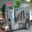

In [20]:
final = (torch.clamp(torch.Tensor(img), -1, 1) + 1) * 0.5
final = T.ToPILImage()(final[0])
final

In [18]:
np.transpose(np.array(img)).shape

(32, 32, 3, 1)

In [19]:
data = {
    'img': np.transpose(np.array(img)).tolist(),
    
}

with open('toymodel/public/truck2.json', 'w') as f:
    json.dump(data, f)

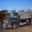

In [132]:
final = (torch.clamp(torch.Tensor(img), -1, 1) + 1) * 0.5
final = T.ToPILImage()(final[0])
final.save("truck-12.png")
final

In [119]:
final

tensor([[[[ 0.0962, -0.1083, -0.2807,  ...,  0.8795,  0.8392,  0.8311],
          [-0.0489, -0.0647, -0.2382,  ...,  0.8800,  0.8629,  0.8600],
          [-0.0984, -0.1901, -0.1840,  ...,  0.7647,  0.8420,  0.8462],
          ...,
          [ 0.6028,  0.5976,  0.6095,  ...,  0.4497,  0.4501,  0.4585],
          [ 0.5957,  0.6137,  0.6304,  ...,  0.4384,  0.4447,  0.4587],
          [ 0.5515,  0.5725,  0.6071,  ...,  0.4511,  0.4511,  0.4342]],

         [[ 0.0854, -0.0882, -0.2644,  ...,  0.9699,  0.9410,  0.9691],
          [-0.0897, -0.0780, -0.2078,  ...,  0.9472,  0.9606,  0.9718],
          [-0.1124, -0.1750, -0.1582,  ...,  0.8304,  0.9076,  0.9519],
          ...,
          [ 0.5979,  0.5641,  0.5806,  ...,  0.3848,  0.3991,  0.3927],
          [ 0.5507,  0.5540,  0.5713,  ...,  0.3767,  0.3833,  0.3841],
          [ 0.5179,  0.5202,  0.5342,  ...,  0.3710,  0.3847,  0.3671]],

         [[-0.2194, -0.4291, -0.5708,  ...,  0.9912,  0.9952,  1.0086],
          [-0.3923, -0.3851, -

In [120]:
img.shape

(1, 3, 32, 32)

In [68]:
outputs = ort_session.run(
    None,
    {
            'image': outputs[0],
            'text_embeds': np.array([1.]).astype(np.float32),
            'text_mask':np.array([1.]).astype(np.float32),
            'timestep': np.array([1.]).astype(np.float32),
            'time_next': np.array([1.]).astype(np.float32),
            'cond_scale': np.array([1.]).astype(np.float32)
    })

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: image Got: 1 Expected: 4 Please fix either the inputs or the model.

In [102]:
outputs[0].shape

(1, 3, 32, 32)

In [30]:
torch.randn(10)

tensor([ 0.4268, -0.7754,  1.7493, -0.3136, -1.4704,  0.1757,  0.6048,  0.3903,
         0.2723,  0.3134])

In [4]:
torch.linspace(0, 1, 25)

tensor([0.0000, 0.0417, 0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333,
        0.3750, 0.4167, 0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083,
        0.7500, 0.7917, 0.8333, 0.8750, 0.9167, 0.9583, 1.0000])

In [11]:
def get_sampling_timesteps(num_timesteps, batch, *, device):
    times = torch.linspace(1., 0., num_timesteps + 1, device = device)
    times = repeat(times, 't -> b t', b = batch)
    times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
    times = times.unbind(dim = -1)
    return times

In [27]:
out = get_sampling_timesteps(250, 1, device=torch.device("cpu"))

In [28]:
len(out)

250

In [29]:
for time, nxt in out:
    print(time, nxt)

tensor([1.]) tensor([0.9960])
tensor([0.9960]) tensor([0.9920])
tensor([0.9920]) tensor([0.9880])
tensor([0.9880]) tensor([0.9840])
tensor([0.9840]) tensor([0.9800])
tensor([0.9800]) tensor([0.9760])
tensor([0.9760]) tensor([0.9720])
tensor([0.9720]) tensor([0.9680])
tensor([0.9680]) tensor([0.9640])
tensor([0.9640]) tensor([0.9600])
tensor([0.9600]) tensor([0.9560])
tensor([0.9560]) tensor([0.9520])
tensor([0.9520]) tensor([0.9480])
tensor([0.9480]) tensor([0.9440])
tensor([0.9440]) tensor([0.9400])
tensor([0.9400]) tensor([0.9360])
tensor([0.9360]) tensor([0.9320])
tensor([0.9320]) tensor([0.9280])
tensor([0.9280]) tensor([0.9240])
tensor([0.9240]) tensor([0.9200])
tensor([0.9200]) tensor([0.9160])
tensor([0.9160]) tensor([0.9120])
tensor([0.9120]) tensor([0.9080])
tensor([0.9080]) tensor([0.9040])
tensor([0.9040]) tensor([0.9000])
tensor([0.9000]) tensor([0.8960])
tensor([0.8960]) tensor([0.8920])
tensor([0.8920]) tensor([0.8880])
tensor([0.8880]) tensor([0.8840])
tensor([0.8840]) t